In [2]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [3]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

In [4]:
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

def get_closest_corners(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    dst = cv2.cornerHarris(blurred, 5, 3, 0.02)
    dst = cv2.dilate(dst, None)
    corners = np.argwhere(dst > 0.01 * dst.max())

    # Find corners closest to image corners
    image_corners = np.array([[0, 0], [0, frame.shape[1]], [frame.shape[0], 0], [frame.shape[0], frame.shape[1]]])
    closest_corners = find_closest_points_to_corners(corners, image_corners)

    return closest_corners

def get_target_points(target_square_size=1000):
    target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)
    return target_points

def get_corner_diff(ref_corners, new_corners):
    ref_corners = np.array(ref_corners)
    new_corners = np.array(new_corners)

    distances = np.linalg.norm(ref_corners - new_corners, axis=1)
    
    return distances

def correct_corners(corners, ref_corners, marked_change):
    updated_corners = corners.copy()
    good_corners = [(corner, id) for id, corner in enumerate(corners) if not marked_change[id]]
    bad_corners = [(corner, id) for id, corner in enumerate(corners) if marked_change[id]]

    num_incorrect = len(bad_corners)
    
    # print(corners)
    if num_incorrect == 0:
        return corners
    if num_incorrect == 4:
        return ref_corners
    
    # if 2 in [id for _, id in good_corners]:
    #     good_corner, g_id = corners[2], 2
        
    # elif 1 in [id for _, id in good_corners]:
    #     good_corner, g_id = corners[1], 1

    # else:
    good_corner, g_id = good_corners[-1]
    
    for bad_corner, b_id in bad_corners:
        delta_x = ref_corners[b_id][0] - ref_corners[g_id][0]
        delta_y = ref_corners[b_id][1] - ref_corners[g_id][1]

        # Update the position of the faulty corner based on the difference
        updated_corners[b_id][0] = good_corner[0] + delta_x
        updated_corners[b_id][1] = good_corner[1] + delta_y
        
        # print(bad_corner, updated_corners[b_id][0], updated_corners[b_id][1])

    return updated_corners

In [7]:
video_path = 'Chess_Data\\chess_medium3.mp4'
video_capture = cv2.VideoCapture(video_path)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = .75
thickness = 2

target_square_size=1000
target_points = get_target_points(target_square_size)

is_first_frame = True
distance_threshold = 7
history_queue = []
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    closest_corners = get_closest_corners(frame)

    if is_first_frame:
        ref_corners = closest_corners.copy()
        is_first_frame = False

    # If change in corners is big, use last accepted reference corners
    distances = get_corner_diff(ref_corners, closest_corners)

    marked_change = [False, False, False, False]
    for c in range(4):
        if distances[c] > distance_threshold:
            marked_change[c] = True

    corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
    ref_corners = corrected_corners.copy()

    homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

    # Apply the perspective transformation
    calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_image.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  

    # Display the result
    # cv2.imshow('Chessboard focus', grid_img)
    
    square_size = grid_division[1] - grid_division[0]

    calibrated_gray = cv2.cvtColor(calibrated_image, cv2.COLOR_BGR2GRAY)
    calibrated_edges = cv2.Canny(calibrated_gray, 50, 150)

    space_img = calibrated_image.copy()

    empty_check_offset = 20
    kernel_size = square_size - empty_check_offset
    artifact_tolerance = 300
    col_imgs = []
    square_color = "Black"
    for x in grid_division[:-1]:
        row_imgs = []
        for y in grid_division[:-1]:
            x_d = x+empty_check_offset//2, x+empty_check_offset//2+kernel_size
            y_d = y+empty_check_offset//2, y+empty_check_offset//2+kernel_size

            edge_board_square = calibrated_edges[x_d[0]:x_d[1], y_d[0]:y_d[1]]
            edge_board_square_bin = np.where(edge_board_square==255, 1, edge_board_square)
            edge_board_square_value = np.sum(edge_board_square_bin)

            row_imgs.append(edge_board_square)
            # imshow(resize_img(edge_board_square, 1))

            if edge_board_square_value > artifact_tolerance:
                # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
                cv2.putText(space_img, f"Figure", (y+16, x+60), font, font_scale, (0, 0, 255), thickness)

            elif edge_board_square_value <= artifact_tolerance:
                # cv2.putText(space_img, f"{square_color} sq", (y+20, x+50), font, font_scale, font_color, thickness)
                cv2.putText(space_img, f"Empty", (y+16, x+60), font, font_scale, (0, 255, 0), thickness)
                
            square_color = "White" if square_color == "Black" else "Black"
                
        square_color = "White" if square_color == "Black" else "Black"

        # imshow(resize_img(np.concatenate(row_imgs, 1), 1))
        col_imgs.append(np.concatenate(row_imgs, 1))

    # cv2.imshow('Labelled_img', space_img)
    cv2.imshow('Labelled_img', calibrated_edges)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

## MOSSE trackers on pieces

In [9]:
def save_first_frame(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read the first frame.")
        return

    # Release the video capture object
    cap.release()

    return frame

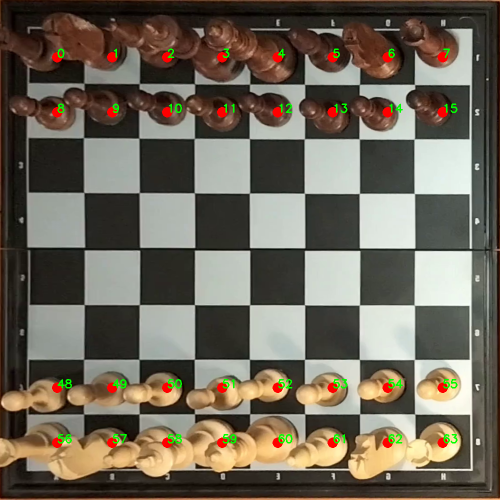

In [21]:
first_frame = save_first_frame(video_path)
closest_corners = get_closest_corners(first_frame)
target_points = get_target_points(target_square_size=1000)

closest_corners = np.array([[[y, x]] for x, y in closest_corners], dtype=int)

homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(first_frame, homography_matrix, (target_square_size, target_square_size))

grid_img = calibrated_image.copy()
offset = 59 # Board edge offset
grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)

middle_offset = (grid_division[1]-grid_division[0])//2

points = []  

i = 0
for x in grid_division[:-1]:
    for y in grid_division[:-1]:
        if i < 16 or i >= 48:
            points.append((y+middle_offset, x+middle_offset))
            cv2.circle(grid_img, (y+middle_offset, x+middle_offset), 5, (0, 0, 255), 10)
            cv2.putText(grid_img, f"{i}",  (y+middle_offset, x+middle_offset), font, font_scale, (0, 255, 0), thickness)
        i+=1

imshow(resize_img(grid_img, 2))

In [29]:
def create_mosse_tracker(image, point, offset=40):
    tracker = cv2.legacy.TrackerMOSSE_create()
    bbox = (point[0]-offset, point[1]-offset, 2*offset, 2*offset)
    tracker.init(image, bbox)
    return tracker, bbox

trackers = []
current_bboxes = []
point_offset = 40
for point in points:
    tracker, bbox = create_mosse_tracker(calibrated_image, point, offset=point_offset)
    current_bboxes.append(bbox)
    trackers.append(tracker)

In [31]:
video_path = 'Chess_Data\\chess_medium3.mp4'
video_capture = cv2.VideoCapture(video_path)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = .75
thickness = 2

target_square_size=1000
target_points = get_target_points(target_square_size)

is_first_frame = True
distance_threshold = 7
history_queue = []
previous_bboxes = current_bboxes.copy()
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    closest_corners = get_closest_corners(frame)

    if is_first_frame:
        ref_corners = closest_corners.copy()
        is_first_frame = False

    # If change in corners is big, use last accepted reference corners
    distances = get_corner_diff(ref_corners, closest_corners)

    marked_change = [False, False, False, False]
    for c in range(4):
        if distances[c] > distance_threshold:
            marked_change[c] = True

    corrected_corners = correct_corners(closest_corners, ref_corners, marked_change)
    ref_corners = corrected_corners.copy()

    homography_matrix, _ = cv2.findHomography(corrected_corners[:,::-1], target_points)

    # Apply the perspective transformation
    calibrated_image = cv2.warpPerspective(frame, homography_matrix, (target_square_size, target_square_size))

    grid_img = calibrated_image.copy()
    offset = 59 # Board edge offset
    grid_division = np.linspace(offset, target_square_size-offset, 9, dtype=int)
    for x in grid_division:
        cv2.line(grid_img, (x, 0+offset), (x, target_square_size-offset), color=(0, 0, 255), thickness=2)  
        cv2.line(grid_img, (0+offset, x), (target_square_size-offset, x), color=(0, 0, 255), thickness=2)  
    
    current_bboxes = []
    successful_ids = [False] * len(trackers)
    # Update the MOSSE trackers
    for i, tracker in enumerate(trackers):
        success, bbox = tracker.update(calibrated_image)
    
        # Draw bounding box around the tracked object
        if success:
            bbox = tuple(map(int, bbox))
            current_bboxes.append(bbox)
            successful_ids[i] = True
            cv2.rectangle(calibrated_image, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 4)
            cv2.circle(calibrated_image, (bbox[0]+40, bbox[1]+40), 5, (0, 255, 0), 10)

        else:
            current_bboxes.append(previous_bboxes[i])

    cv2.imshow('MOSSE Tracker', calibrated_image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()